## 过拟合和欠拟合

In [1]:
import sys
import os
import pathlib
import shutil
import tempfile
from IPython import display

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import pandas as pd
import numpy as np


%matplotlib inline

print("python version: ", sys.version_info)
for module in np, mpl, tf, keras, pd:
    print(module.__name__, "version: ", module.__version__)
    
seed = 10383

python version:  sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
numpy version:  1.16.0
matplotlib version:  3.0.3
tensorflow version:  2.3.0
tensorflow.keras version:  2.4.0
pandas version:  0.24.2


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

### 1. Higgs Dataset

包含11 000 000条样本，每条样本包含 28 个特征，以及 1 个二值标签

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [4]:
FEATURES = 28

tf.data.experimental.CsvDataset 可以直接从 gzip 文件读取 csv 数据，无需中间的解压缩步骤。

In [5]:
ds = tf.data.experimental.CsvDataset(gz, [float(),] * (FEATURES + 1), compression_type="GZIP")

该csv阅读器类为每个记录返回一个标量列表。 以下函数将该标量列表重新打包为（feature_vector，label）对。

In [6]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

当处理大量数据时，TensorFlow效率最高。  
  
因此，与其单独重新打包每一行，不如创建一个新的数据集，该数据集采用10000个示例的批次，将pack_row函数应用于每个批次，然后将这些批次拆分回各个记录：

In [7]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


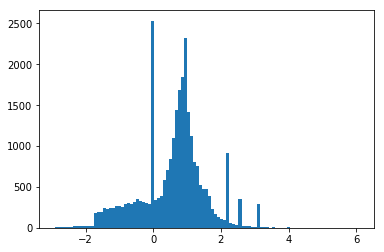

In [8]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

为了使本教程相对较短，仅使用前1000个样本进行验证，然后使用10000个样本进行培训：

In [9]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

Dataset.skip和Dataset.take方法使此操作变得容易。  
同时，使用Dataset.cache方法来确保加载器不需要在每个时期重新从文件中读取数据：  

In [10]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [11]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

这些数据集返回单个示例。 使用.batch方法可创建适当大小的批次进行训练。 批处理之前，还记得.shuffle和.repeat训练集。

In [12]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### 2. 过拟合示范

#### 2.1 训练过程

如果在训练过程中逐渐降低学习率，许多模型的训练效果会更好。 使用optimizers.schedules可以随着时间的推移降低学习率：

In [13]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=STEPS_PER_EPOCH * 1000, decay_rate=1, staircase=False
)


def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

上面的代码设置了一个schedules.InverseTimeDecay，以双曲线的方式将学习速率在1000个时代降低到基本速率的1/2，在2000个时代降低1/3，依此类推。

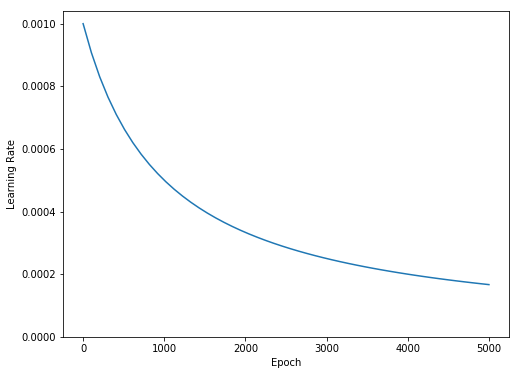

In [14]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")

本教程中的每个模型都将使用相同的训练配置。 因此，从回调列表开始，以可重用的方式设置它们。  
  
本教程的培训会持续很短的时间。 为了减少记录噪音，请使用 **tfdocs.EpochDots** ，它仅显示一个 **.** 每个时期，以及每100个时期的完整指标。  
  
接下来包括 **callbacks.EarlyStopping** 以避免冗长和不必要的培训时间。 请注意，此回调设置为监视 **val_binary_crossentropy** ，而不是 **val_loss** 。 这种差异稍后将变得很重要。  
   
使用 **callbacks.TensorBoard** 生成用于训练的TensorBoard日志。

In [15]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_binary_crossentropy", patience=200
        ),
        tf.keras.callbacks.TensorBoard(logdir / name),
    ]

同样，每个模型将使用相同的Model.compile和Model.fit设置：

In [16]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.losses.BinaryCrossentropy(
                from_logits=True, name="binary_crossentropy"
            ),
            "accuracy",
        ],
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0,
    )
    return history

#### 2.2 极小的模型

In [17]:
tiny_model = tf.keras.Sequential([
    keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(1)
])

In [18]:
size_histories = {}

In [19]:
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch: 0, accuracy:0.4933,  binary_crossentropy:0.7335,  loss:0.7335,  val_accuracy:0.4750,  val_binary_crossentropy:0.7211,  val_loss:0.7211,  
....................................................................................................
Epoch: 100, accuracy:0.6045,  binary_crossentropy:0.6247,  loss:0.6247,  val_accuracy:0.5820,  val_binary_crossentropy:0.6308,  val_loss:0.6308,  
......................................................

(0.5, 0.7)

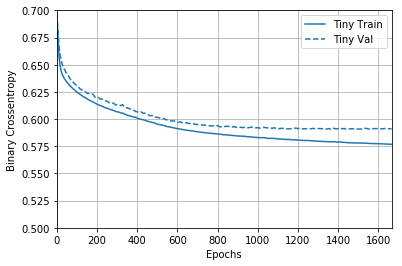

In [20]:
plotter = tfdocs.plots.HistoryPlotter(metric="binary_crossentropy", smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

#### 2.3 小的模型

In [21]:
small_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
    keras.layers.Dense(16, activation="elu"),
    keras.layers.Dense(1)
])

In [22]:
size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4680,  binary_crossentropy:0.7240,  loss:0.7240,  val_accuracy:0.4770,  val_binary_crossentropy:0.7020,  val_loss:0.7020,  
....................................................................................................
Epoch: 100, accuracy:0.6406,  binary_crossentropy:0.6009,  loss:0.6009,  val_accuracy:0.6260,  val_binary_crossentropy:0.6022,  val_loss:0.

#### 2.4 中等模型

In [23]:
medium_model = keras.Sequential([
    keras.layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(64, activation="elu"),
    keras.layers.Dense(1)
])

In [24]:
size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4941,  binary_crossentropy:0.7020,  loss:0.7020,  val_accuracy:0.4720,  val_binary_crossentropy:0.6812,  val_loss:0.6812,  
....................................................................................................
E

#### 2.5 大模型

In [25]:
large_model = keras.Sequential([
    keras.layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
    keras.layers.Dense(512, activation="elu"),
    keras.layers.Dense(512, activation="elu"),
    keras.layers.Dense(512, activation="elu"),
    keras.layers.Dense(1)
])

In [26]:
size_histories["large"] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5030,  binary_crossentropy:0.7861,  loss:0.7861,  val_accuracy:0.5470,  val_binary_crossentr

#### 2.6 绘制损失图

在此示例中，通常，只有“ Tiny”模型设法避免完全过拟合，并且每个较大的模型都更快地过拟合数据。 对于“大型”模型而言，这变得如此严重，以至于您需要将绘图切换为对数比例才能真正看到正在发生的事情。  
* 差异很小是正常的。  
  
* 如果两个指标都朝着同一方向发展，那么一切都很好。  
  
* 如果在培训指标继续提高的同时，验证指标开始停滞不前，那么您可能已经过拟合了。  
  
* 如果验证指标的方向错误，则表明该模型过度拟合。  

Text(0.5, 0, 'Epochs [Log Scale]')

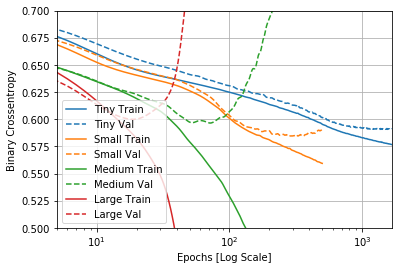

In [27]:
plotter.plot(size_histories)
a = plt.xscale("log")
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

#### 2.7 在TensorBoard中显示

In [28]:
%load_ext tensorboard
%tensorboard --logdir {logdir}/sizes

In [41]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%",
    height="800px",
)

### 3. 阻止过拟合的策略

复制上面“ Tiny”模型中的训练日志，以用作比较的基准。

In [29]:
shutil.rmtree(logdir / "regularizers/Tiny", ignore_errors=True)
shutil.copytree(logdir / "sizes/Tiny", logdir / "regularizers/Tiny")

PosixPath('/var/folders/f5/ndqlrckj6_924k3kxxx7wd0r0000gn/T/tmpk92iyid3/tensorboard_logs/regularizers/Tiny')

In [30]:
regularizer_histories = {}
regularizer_histories["Tiny"] = size_histories["Tiny"]

#### 3.1 正则化

In [31]:
l2_model = keras.Sequential([
    keras.layers.Dense(512, activation="elu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(FEATURES,)),
    keras.layers.Dense(512, activation="elu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(512, activation="elu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(512, activation="elu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(1)
])

regularizer_histories["l2"] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5039,  binary_crossentropy:0.8298,  loss:2.3591,  val_accuracy:0.5610,  val_binary_crossentr

(0.5, 0.7)

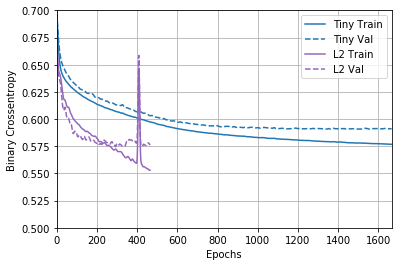

In [32]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

#### 3.2 dropout

In [34]:
dropout_model = keras.Sequential([
    keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

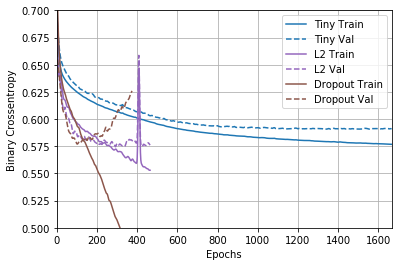

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

#### 3.3 L2正则与dropout结合

In [37]:
combined_model = keras.Sequential(
    [
        keras.layers.Dense(
            512,
            kernel_regularizer=keras.regularizers.l2(0.0001),
            activation="elu",
            input_shape=(FEATURES,),
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
            512, kernel_regularizer=keras.regularizers.l2(0.0001), activation="elu"
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
            512, kernel_regularizer=keras.regularizers.l2(0.0001), activation="elu"
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
            512, kernel_regularizer=keras.regularizers.l2(0.0001), activation="elu"
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1),
    ]
)

regularizer_histories["combined"] = compile_and_fit(
    combined_model, "regularizers/combined"
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

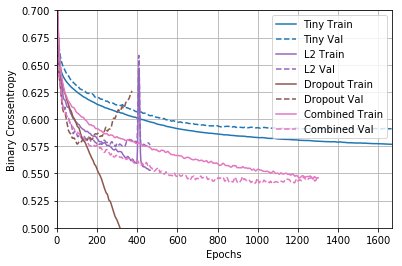

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

#### 3.4 在TensorBoard中显示

In [39]:
%tensorboard --logdir {logdir}/regularizers

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width="100%",
    height="800px",
)

### 4. 总结

以下是防止神经网络过度拟合的最常用方法：  
1. 获取更多的训练数据；  
2. 减小网络的容量；  
3. 正则化；
4. dropout。  
  
请记住，每种方法都可以单独提供帮助，但通常将它们组合起来会更加有效。  